# Ethiopia Crop Productivity Analysis

This notebook uses Enhanced Vegetation Index (EVI) from MODIS as a proxy for crop yield. EVI measures canopy greeness by analyzing spectral data through satellite imagery. EVI serves as a proxy for crop yield because it measures photosynthetic activity and green biomass, which strongly correlate with a crop's potential productivity and final harvest output. 

## Methodology Summary

1. Download imagery from MODIS for Ethiopia from 2012-2024. 
2. Get Crop Mask data for Ethiopia from Digital Earth Africa
3. Estimate area of crop land in each admin region 
4. Use 2021-2023 data as a baseline to identify growing season in Ethiopia
5. Use the growing season to track difference in EVI in 2024 compared to a 10 year average (2012-2022)
6. Plot trends in EVI over the last decade



In [3]:
import ee
import os

# Force reauthentication with proper scopes
ee.Authenticate()

# Then initialize with your project
ee.Initialize()


Successfully saved authorization token.


In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../training-253313-c905674c1ca0.json"

In [2]:
import sys
#gee_zonal_module_path = r"D:/WB/GEE_Zonal/src"
#sys.path.append(gee_zonal_module_path)

# Now, import the zonal_stats and gee_helpers modules
#import zonalstats
#import gee_helpers
from gee_zonal import *
from gee_zonal import gee_helpers
import geopandas as gpd
import pandas as pd
import numpy as np
import ee
from geemap.conversion import *
import matplotlib.pyplot as plt
import requests
import rasterio
from rasterio.mask import mask
#from gee_helpers import gpd_to_gee
import json
import folium
import branca.colormap as cm
import importlib
import ast
import rasterio
from branca.colormap import LinearColormap
import base64
from io import BytesIO
#import calculate_areas


In [4]:
# loading boundaries 
eth_adm0 = gpd.read_file("../../data/boundaries/eth_admbnda_adm0_csa_bofedb_itos_2021.shp")
eth_adm1 = gpd.read_file("../../data/boundaries/eth_admbnda_adm1_csa_bofedb_2021.shp")
eth_adm2 = gpd.read_file("../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp")
eth_adm3 = gpd.read_file("../../data/boundaries/eth_admbnda_adm3_csa_bofedb_2021.shp")

In [5]:
# Extracting centroid values
centroid = eth_adm0['geometry'].iloc[0].centroid
centy, centx = centroid.x, centroid.y

In [6]:
aoi_adm1 = gpd_to_gee(eth_adm1)

**MODIS**


We utilize Google Earth Engine to access the Enhanced Vegetation Index (EVI) band from the [MODIS satellite](https://modis.gsfc.nasa.gov/about/). By combining data from [Terra](https://lpdaac.usgs.gov/products/mod13q1v061/) and [Aqua](https://lpdaac.usgs.gov/products/myd13q1v061/), we obtain a map of EVI at 250 meters resolution every 16-days from 2012 to 2024. 

The enhanced vegetation index (EVI) is an 'optimized' vegetation index designed to enhance the vegetation signal with improved vegetation monitoring through a de-coupling of the canopy background signal and a reduction in atmosphere influences.

We apply the necessary data masking steps:
1. Mask out bad quality data (shadows/clouds)
2. Mask out non-crop areas using the DEA crop layer.


In [7]:
eth_adm0.to_file("../../data/boundaries/ethiopia_adm0.geojson", driver='GeoJSON')


with open("../../data/boundaries/ethiopia_adm0.geojson") as f:
    eth_geometry = json.load(f)
eth_geometry = ee.Geometry(eth_geometry['features'][0]['geometry'])

In [20]:
# MODIS EVI Export to TIFF Files - Complete Code with Date Preservation Fix
import ee
import os
from datetime import datetime

# Initialize Earth Engine (make sure you're authenticated)
ee.Initialize()

# Define your study area geometry (replace with your eth_geometry)
# Example for Ethiopia - replace with your actual geometry
eth_geometry = ee.Geometry.Rectangle([32.5, 3.0, 48.0, 15.0])  # Rough Ethiopia bounds

#MODIS Data for EVI
start_period = ee.Date("2023-01-01")
end_period = ee.Date("2024-12-31")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")

#----------------------BITWISE MASKING---------------------------------------
def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}

#Applying DEA Cropmask
dea = ee.ImageCollection(
    "projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/mask"
).mosaic()
crop_data_dea = dea.select("b1").rename("crop").clip(eth_geometry)
crop_data_viz_dea = crop_data_dea.mask(crop_data_dea.gt(0))

scale_factor = 0.0001

# apply cropland mask to imageCollection
def cropmask(img):
    return img.updateMask(crop_data_dea).clip(eth_geometry).multiply(scale_factor) # unmask(-1)

mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)

# Export configuration for Google Cloud Storage
gcs_bucket = "your-bucket-name"  # Replace with your GCS bucket name
output_folder = "MODIS_EVI_Ethiopia"
crs = 'EPSG:4326'  # WGS84 geographic coordinate system
scale = 250  # 250m resolution for MOD13Q1

# Function to export individual images to GCS
def export_image_to_gcs(image, date_str, description):
    """
    Export a single MODIS EVI image to Google Cloud Storage as GeoTIFF
    """
    task = ee.batch.Export.image.toCloudStorage(
        image=image,
        description=description,
        bucket=gcs_bucket,
        fileNamePrefix=f"{output_folder}/EVI_{date_str}",
        scale=scale,
        region=eth_geometry,
        crs=crs,
        maxPixels=1e9,
        fileFormat='GeoTIFF',
        formatOptions={
            'cloudOptimized': True,  # Create cloud-optimized GeoTIFF
            'noData': -9999
        }
    )
    task.start()
    print(f"Started export task: {description}")
    return task

# Date preservation method: Get dates before processing
def get_dates_from_original_collection():
    """Get dates from the original collection before masking"""
    # Get dates from the original merged collection
    def add_date_band(img):
        date_millis = img.get('system:time_start')
        date_img = ee.Image.constant(date_millis).rename('date_millis')
        return img.addBands(date_img)
    
    # Add date band to original collection
    modis_with_dates = mxd13q1_cleaned_sorted.map(add_date_band)
    
    # Apply cropmask while preserving date band
    def cropmask_with_date(img):
        evi = img.select('EVI').updateMask(crop_data_dea).clip(eth_geometry).multiply(scale_factor)
        date_band = img.select('date_millis')
        return evi.addBands(date_band).copyProperties(img, ['system:time_start'])
    
    return modis_with_dates.map(cropmask_with_date)

# Use the date preservation approach
print("Getting collection with preserved dates...")
mxd13q1_with_dates = get_dates_from_original_collection()
collection_size = mxd13q1_with_dates.size().getInfo()
print(f"Total number of images to export: {collection_size}")

image_list = mxd13q1_with_dates.toList(collection_size)

# Export each image
export_tasks = []
for i in range(collection_size):
    try:
        img = ee.Image(image_list.get(i))
        
        # Get date from the date band we added
        try:
            date_millis = img.select('date_millis').reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=img.geometry().centroid(),
                scale=250,
                maxPixels=1
            ).get('date_millis').getInfo()
            
            if date_millis:
                date_obj = datetime.fromtimestamp(date_millis / 1000.0)
                date_str = date_obj.strftime("%Y_%m_%d")
            else:
                date_str = f"image_{i+1:03d}"
                
        except Exception as date_error:
            print(f"Date extraction failed for image {i+1}: {date_error}")
            date_str = f"image_{i+1:03d}"
        
        # Select only EVI band for export (excluding the date band)
        evi_img = img.select('EVI')
        
        description = f"MODIS_EVI_Ethiopia_{date_str}_{i+1:03d}"
        task = export_image_to_gcs(evi_img, date_str, description)
        export_tasks.append(task)
        
        print(f"Queued export {i+1}/{collection_size}: {date_str}")
        
    except Exception as e:
        print(f"Error processing image {i+1}: {e}")
        continue

print(f"\nAll {len(export_tasks)} export tasks have been started!")
print(f"Files will be saved to: gs://{gcs_bucket}/{output_folder}/")

# Function to check task status
def check_task_status():
    """
    Check the status of all export tasks
    """
    print("\nChecking task status...")
    completed = 0
    failed = 0
    running = 0
    
    for i, task in enumerate(export_tasks):
        status = task.status()
        state = status['state']
        
        if state == 'COMPLETED':
            completed += 1
        elif state == 'FAILED':
            failed += 1
            print(f"Task {i+1} FAILED: {status.get('error_message', 'Unknown error')}")
        elif state in ['RUNNING', 'READY']:
            running += 1
    
    print(f"Status Summary:")
    print(f"  Completed: {completed}")
    print(f"  Running: {running}")
    print(f"  Failed: {failed}")
    print(f"  Total: {len(export_tasks)}")
    
    return completed, running, failed

# Check initial status
check_task_status()

print("\nTo monitor progress, run: check_task_status()")
print("To cancel all tasks, run: [task.cancel() for task in export_tasks]")

# Optional: Function to export a subset of images (e.g., for testing)
def export_subset(start_index=0, end_index=5):
    """
    Export only a subset of images for testing
    """
    print(f"\nExporting subset: images {start_index} to {end_index}")
    
    subset_tasks = []
    for i in range(start_index, min(end_index, collection_size)):
        try:
            img = ee.Image(image_list.get(i))
            
            # Get date from the date band
            try:
                date_millis = img.select('date_millis').reduceRegion(
                    reducer=ee.Reducer.first(),
                    geometry=img.geometry().centroid(),
                    scale=250,
                    maxPixels=1
                ).get('date_millis').getInfo()
                
                if date_millis:
                    date_obj = datetime.fromtimestamp(date_millis / 1000.0)
                    date_str = date_obj.strftime("%Y_%m_%d")
                else:
                    date_str = f"image_{i+1:03d}"
            except:
                date_str = f"image_{i+1:03d}"
            
            evi_img = img.select('EVI')
            description = f"MODIS_EVI_Ethiopia_SUBSET_{date_str}_{i+1:03d}"
            task = export_image_to_gcs(evi_img, date_str, description)
            subset_tasks.append(task)
            
            print(f"Queued subset export {i+1}: {date_str}")
        except Exception as e:
            print(f"Error in subset export {i+1}: {e}")
            continue
    
    return subset_tasks

# Uncomment the line below to export only the first 3 images for testing:
# test_tasks = export_subset(0, 3)

Getting collection with preserved dates...
Total number of images to export: 92
Started export task: MODIS_EVI_Ethiopia_2022_12_31_001
Queued export 1/92: 2022_12_31
Started export task: MODIS_EVI_Ethiopia_2023_01_08_002
Queued export 2/92: 2023_01_08
Started export task: MODIS_EVI_Ethiopia_2023_01_16_003
Queued export 3/92: 2023_01_16
Started export task: MODIS_EVI_Ethiopia_2023_01_24_004
Queued export 4/92: 2023_01_24
Started export task: MODIS_EVI_Ethiopia_2023_02_01_005
Queued export 5/92: 2023_02_01
Started export task: MODIS_EVI_Ethiopia_2023_02_09_006
Queued export 6/92: 2023_02_09
Started export task: MODIS_EVI_Ethiopia_2023_02_17_007
Queued export 7/92: 2023_02_17
Started export task: MODIS_EVI_Ethiopia_2023_02_25_008
Queued export 8/92: 2023_02_25
Started export task: MODIS_EVI_Ethiopia_2023_03_05_009
Queued export 9/92: 2023_03_05
Started export task: MODIS_EVI_Ethiopia_2023_03_13_010
Queued export 10/92: 2023_03_13
Started export task: MODIS_EVI_Ethiopia_2023_03_21_011
Queu

In [19]:
from datetime import datetime

gcs_bucket = "datapartnership-agriculture"
output_folder = "MODIS_EVI_Ethiopia"
scale = 250  
crs = "EPSG:4326"  

# Fixed date handling function
def get_date_string(img):
    """Get formatted date string from Earth Engine image"""
    try:
        # Get date from system:time_start
        date_millis = img.get('system:time_start').getInfo()
        # Convert milliseconds to seconds and create datetime object
        date_obj = datetime.fromtimestamp(date_millis / 1000.0)
        return date_obj.strftime("%Y_%m_%d")
    except Exception as e:
        print(f"Error getting date: {e}")
        # Fallback to system index if date fails
        return f"unknown_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Function to export individual images to GCS
def export_image_to_gcs(image, date_str, description):
    """
    Export a single MODIS EVI image to Google Cloud Storage as GeoTIFF
    """
    task = ee.batch.Export.image.toCloudStorage(
        image=image,
        description=description,
        bucket=gcs_bucket,
        fileNamePrefix=f"{output_folder}/EVI_{date_str}",
        scale=scale,
        region=eth_geometry,
        crs=crs,
        maxPixels=1e9,
        fileFormat='GeoTIFF',
        formatOptions={
            'cloudOptimized': True,  # Create cloud-optimized GeoTIFF
            'noData': -9999
        }
    )
    task.start()
    print(f"Started export task: {description}")
    return task

# Get the size of the collection first
collection_size = mxd13q1.size().getInfo()
print(f"Total number of images to export: {collection_size}")

# Convert collection to list for iteration
image_list = mxd13q1.toList(collection_size)

# Export each image
export_tasks = []

for i in range(collection_size):
    try:
        # Get the image from the list
        img = ee.Image(image_list.get(i))
        
        # Get formatted date string
        date_str = get_date_string(img)
        
        # Create description
        description = f"MODIS_EVI_Ethiopia_{date_str}_{i+1:03d}"
        
        # Export the image
        task = export_image_to_gcs(img, date_str, description)
        export_tasks.append(task)
        
        print(f"Queued export {i+1}/{collection_size}: {date_str}")
        
    except Exception as e:
        print(f"Error processing image {i+1}: {e}")
        continue

print(f"\nAll {len(export_tasks)} export tasks have been started!")
print(f"Files will be saved to: gs://{gcs_bucket}/{output_folder}/")

# Function to check task status
def check_task_status():
    """
    Check the status of all export tasks
    """
    print("\nChecking task status...")
    completed = 0
    failed = 0
    running = 0
    
    for i, task in enumerate(export_tasks):
        status = task.status()
        state = status['state']
        
        if state == 'COMPLETED':
            completed += 1
        elif state == 'FAILED':
            failed += 1
            print(f"Task {i+1} FAILED: {status.get('error_message', 'Unknown error')}")
        elif state in ['RUNNING', 'READY']:
            running += 1
    
    print(f"Status Summary:")
    print(f"  Completed: {completed}")
    print(f"  Running: {running}")
    print(f"  Failed: {failed}")
    print(f"  Total: {len(export_tasks)}")
    
    return completed, running, failed

# Check initial status
check_task_status()

print("\nTo monitor progress, run: check_task_status()")
print("To cancel all tasks, run: [task.cancel() for task in export_tasks]")

# Optional: Function to export a subset of images (e.g., for testing)
def export_subset(start_index=0, end_index=5):
    """
    Export only a subset of images for testing
    """
    print(f"\nExporting subset: images {start_index} to {end_index}")
    
    subset_tasks = []
    for i in range(start_index, min(end_index, collection_size)):
        img = ee.Image(image_list.get(i))
        
        date_millis = img.get('system:time_start').getInfo()
        date_obj = datetime.fromtimestamp(date_millis / 1000.0)
        date_str = date_obj.strftime("%Y_%m_%d")
        
        description = f"MODIS_EVI_Ethiopia_SUBSET_{date_str}_{i+1:03d}"
        task = export_image_to_gcs(img, date_str, description)
        subset_tasks.append(task)
        
        print(f"Queued subset export {i+1}: {date_str}")
    
    return subset_tasks

# Alternative: More efficient batch export function
def export_batch_efficient(batch_size=10):
    """
    Export images in batches to avoid memory issues with large collections
    """
    print(f"Exporting {collection_size} images in batches of {batch_size}")
    
    all_tasks = []
    for batch_start in range(0, collection_size, batch_size):
        batch_end = min(batch_start + batch_size, collection_size)
        print(f"\nProcessing batch: {batch_start+1} to {batch_end}")
        
        for i in range(batch_start, batch_end):
            img = ee.Image(image_list.get(i))
            
            # Get date
            date_millis = img.get('system:time_start').getInfo()
            date_obj = datetime.fromtimestamp(date_millis / 1000.0)
            date_str = date_obj.strftime("%Y_%m_%d")
            
            # Export
            description = f"MODIS_EVI_Ethiopia_BATCH_{date_str}_{i+1:03d}"
            task = export_image_to_gcs(img, date_str, description)
            all_tasks.append(task)
            
            print(f"  Queued: {date_str}")
    
    return all_tasks

test_tasks = export_subset(0, 2)

Total number of images to export: 92
Error getting date: unsupported operand type(s) for /: 'NoneType' and 'float'
Started export task: MODIS_EVI_Ethiopia_unknown_20250616_143148_001
Queued export 1/92: unknown_20250616_143148
Error getting date: unsupported operand type(s) for /: 'NoneType' and 'float'
Started export task: MODIS_EVI_Ethiopia_unknown_20250616_143151_002
Queued export 2/92: unknown_20250616_143151
Error getting date: unsupported operand type(s) for /: 'NoneType' and 'float'
Started export task: MODIS_EVI_Ethiopia_unknown_20250616_143156_003
Queued export 3/92: unknown_20250616_143156
Error getting date: unsupported operand type(s) for /: 'NoneType' and 'float'
Started export task: MODIS_EVI_Ethiopia_unknown_20250616_143200_004
Queued export 4/92: unknown_20250616_143200
Error getting date: unsupported operand type(s) for /: 'NoneType' and 'float'
Started export task: MODIS_EVI_Ethiopia_unknown_20250616_143204_005
Queued export 5/92: unknown_20250616_143204
Error getting

KeyboardInterrupt: 

In [9]:
bool_dict = {
    "0": "non_crop",
    "1": "crop",
}
#Number of crop pixels in each admin region

zs = ZonalStats(
    target_features=aoi_adm1,
    statistic_type="count",
    scale=10,
    ee_dataset=crop_data_dea,
    output_name="adm1_crop_count",
    output_dir="GEE_ETH",
)

In [71]:
zs.runZonalStats()

# Run this only when export is being done to GDrive
zs.reportRunTime()

Status is Ready, hasn't started


## Findings

### Croparea Statistics


In [11]:
adm1_cropcount_path = "../../data/agriculture/adm1_crop_count.csv"
df = pd.read_csv(adm1_cropcount_path)

def load_dict(input_str):
    input_str = input_str.replace("null", "'null'")
    input_str = input_str.replace("=", ":")
    result_dict = ast.literal_eval(input_str)
    return result_dict


df.loc[:, "histogram"] = df.apply(lambda x: load_dict(x["histogram"]), axis=1)

bool_dict = {
    0: "non_crop",
    1: "crop",
}
histograms = df["histogram"]
histograms_dfs = [
    pd.DataFrame(index=[idx], data=hist_dict) for idx, hist_dict in histograms.items()
]
histogram_df = pd.concat(histograms_dfs, axis=0).fillna(0)
histogram_df.rename(columns=bool_dict, inplace=True)

df = df.join(histogram_df)
df = df.sort_values(by="crop", ascending=False)
df.loc[:, "Crop Area ha."] = ((df["crop"] * 100) / 10000).apply(lambda x: f"{x:,.0f}")
df.loc[:, "Crop Area Share (% of Region)"] = (
    df["crop"] / (df["crop"] + df["non_crop"])
).apply(lambda x: f"{x:.2%}")
df.loc[:, "Crop Area Share (% of Country)"] = (df["crop"] / (df["crop"].sum())).apply(
    lambda x: f"{x:.2%}"
)
df.rename(columns={"ADM1_EN": "Region"}, inplace=True)
df[
    [
        "Region",
        "Crop Area ha.",
        "Crop Area Share (% of Country)",
        "Crop Area Share (% of Region)",
    ]
].reset_index(drop=True)

,Region,Crop Area ha.,Crop Area Share (% of Country),Crop Area Share (% of Region)
0,Oromia,"10,090,333",42.00%,36.55%
1,Amhara,"6,429,973",26.76%,48.91%
2,SNNP,"2,298,187",9.57%,41.02%
3,Tigray,"2,092,136",8.71%,44.66%
4,South West Ethiopia,"1,343,857",5.59%,41.75%
5,Benishangul Gumz,"918,617",3.82%,18.78%
6,Sidama,"349,321",1.45%,53.70%
7,Gambela,"191,895",0.80%,7.19%
8,Somali,"175,187",0.73%,0.58%
9,Afar,"106,551",0.44%,1.18%


In [12]:
crop_admin_regions = df.sort_values(by="crop", ascending=False)['Region'].head(6).to_list()

In [13]:
aoi = gpd_to_gee(eth_adm0)

In [50]:
mxd13q1_recent = mxd13q1.filterDate("2019-01-01", "2024-12-31")

zs = ZonalStats(
    ee_dataset=mxd13q1_recent,          # this is your EVI time series
    target_features=aoi,
    statistic_type="median",
    scale=250,
    output_name="eth_phenology",
    output_dir="GEE_ETH"
)

zs.runZonalStats()

# Convert to phenology_df structure
#phenology_df = evi_df.pivot(index="date", columns="region", values="mean")


In [14]:
evi_df = pd.read_csv('../../data/agriculture/eth_phenology.csv')

In [57]:
# Step 1: Keep only EVI columns and metadata
evi_columns = [col for col in evi_df.columns if "_EVI" in col]
meta_columns = ['ADM0_EN', 'ADM0_PCODE']  # Adjust as needed
df_subset = evi_df[meta_columns + evi_columns]

# Step 2: Melt into long format
df_long = df_subset.melt(id_vars=meta_columns, 
                         value_vars=evi_columns,
                         var_name="band_date", 
                         value_name="EVI")

# Step 3: Extract proper date
df_long["date"] = pd.to_datetime(df_long["band_date"].str.extract(r'(\d{4}_\d{2}_\d{2})')[0], format="%Y_%m_%d")

# Optional: Clean region label
df_long.rename(columns={"ADM0_EN": "region"}, inplace=True)

phenology_df = df_long.pivot(index="date", columns="region", values="EVI")


In [58]:
#scaling factor for MODIS
phenology_df = phenology_df/10000

In [59]:
from scipy.signal import savgol_filter

def preprocess_series(series):
    """TIMESAT-style preprocessing."""
    series = series.interpolate(limit_direction="both")  # Step 2: Interpolate
    median = series.rolling(window=5, center=True).median()
    std_dev = series.std()
    series = series.mask((series - median).abs() > 2 * std_dev)  # Step 1: Remove outliers
    series = series.interpolate(limit_direction="both")
    smoothed = savgol_filter(series, window_length=5, polyorder=2)  # Step 3: Smooth
    return smoothed

def extract_sos_mos_eos(smoothed, dates, threshold=0.2):
    max_val = smoothed.max()
    min_val = smoothed.min()
    amp = max_val - min_val
    sos = mos = eos = None
    for i in range(1, len(smoothed)):
        if sos is None and smoothed[i] > min_val + threshold * amp:
            sos = dates[i]
        if smoothed[i] == max_val:
            mos = dates[i]
        if sos is not None and smoothed[i] < min_val + threshold * amp:
            eos = dates[i]
            break
    return sos, mos, eos


In [60]:
monthly_df = phenology_df.copy()
monthly_df["month"] = monthly_df.index.month
monthly_df = monthly_df.groupby("month").mean()

In [63]:
season_dict = {}

for region in monthly_df.columns:
    series = monthly_df[region]
    smoothed = preprocess_series(series)
    sos, mos, eos = extract_sos_mos_eos(smoothed, monthly_df.index)
    #print(sos, region, eos)
    season_dict[region] = {"SOS": sos, "MOS": mos, "EOS": eos}
    #print(f"{region}: SOS={sos.date()}, MOS={mos.date()}, EOS={eos.date()}")


### Crop Seasonality
Using this time series dataset of EVI images, we apply several pre-processing steps to extract critical phenological parameters: start of season (SOS), middle of season (MOS), end of season (EOS), length of season (LOS), etc. This workflow is heavily inspired by the [TIMESAT](https://web.nateko.lu.se/timesat/timesat.asp) software, although in this implementation we use the [Phenolopy](https://github.com/frontiersi/phenolopy/tree/main) open-source package.  

**Pre-processing steps**  
1. Remove outliers from dataset on per-pixel basis using median method: outlier if median from a moving window < or > standard deviation of time-series times 2.
2. Interpolate missing values linearly
3. Smooth data on per-pixel basis (using Savitsky Golay filter, window length of 3, and polyorder of 1)  

**Phenology Process**  
We then extract crop seasonality metrics using the seasonal amplitude method from the phenolopy package. 

The chart below shows the result of this process for a single crop pixel. The green dots represent the raw EVI values, the black line represents the processed EVI values, and the red dotted lines represent season parameters extracted for that pixel: start of season, peak of season, and end of season.

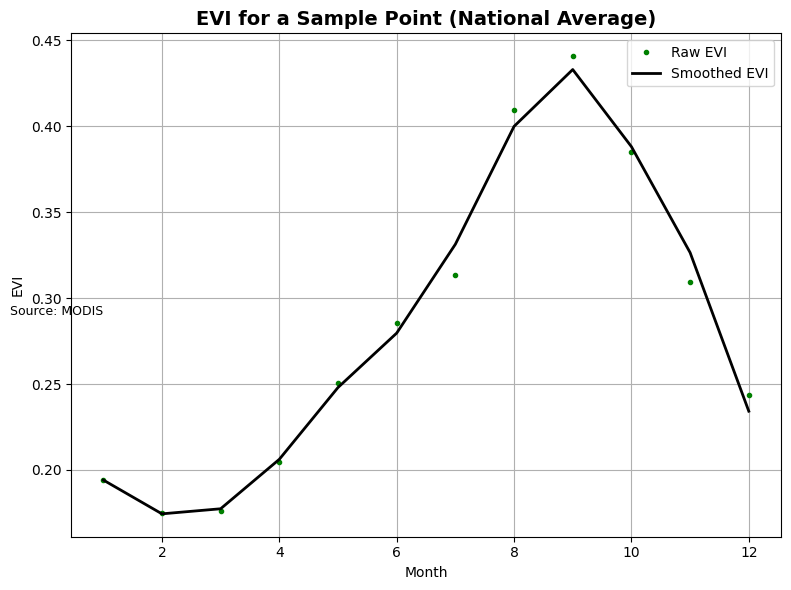

In [68]:
df = monthly_df

plt.figure(figsize=(8, 6))
plt.plot(df.index, df, 'o', color='green', markersize=3, label="Raw EVI")
plt.plot(df.index, smoothed, 'k-', linewidth=2, label="Smoothed EVI")
# for date in [sos, mos, eos]:
#     plt.axvline(date, color='red', linestyle='--')
plt.title("EVI for a Sample Point (National Average)", fontsize=14, weight='bold')
plt.ylabel("EVI")
plt.xlabel("Month")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.text(df.index[0], 0.29, "Source: MODIS", fontsize=9, ha='right')
plt.savefig('../../docs/images/agriculture/season.png', dpi=300, bbox_inches='tight')
plt.show()



**Based on the phenology process, we identified the seasonality to start in April/May and end in December with the peak being in September.** This can vary with geographic region and crop type as well, however, that has not been taken into consideration in this version. 

In [25]:
# Define function to calculate EVI z-score for a given year
def calculate_evi_zscore(year, mxd13q1, historical_median, historical_stddev, geometry, growing_season):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Calculate median EVI for the year's growing season
    year_evi = mxd13q1.filterDate(start_date, end_date) \
                      .filter(growing_season) \
                      .median() \
                      .clip(geometry)
    
    # Calculate Z-score: (current - median) / stdDev
    evi_zscore = year_evi.subtract(historical_median) \
                         .divide(historical_stddev) \
                         .rename('EVI_ZScore')
    
    return evi_zscore

In [11]:
def calculate_evi_zscores_from_baseline(mxd13q1, eth_geometry, 
                                   baseline_start, baseline_end, 
                                   target_years, 
                                   growing_season_start=4, growing_season_end=11):
    """
    Calculate EVI z-scores for multiple years against a flexible baseline period.
    
    Parameters:
    - mxd13q1: Earth Engine ImageCollection
    - eth_geometry: Earth Engine Geometry for clipping
    - baseline_start: Start year for baseline period (e.g., '2012')
    - baseline_end: End year for baseline period (e.g., '2022')
    - target_years: List of years to calculate z-scores for (e.g., [2023, 2024])
    - growing_season_start: Start month of growing season (default: 4 = April)
    - growing_season_end: End month of growing season (default: 11 = November)
    
    Returns:
    - Dictionary with years as keys and z-score images as values
    """
    
    # Define growing season filter
    growing_season = ee.Filter.calendarRange(growing_season_start, growing_season_end, 'month')
    
    # Calculate baseline statistics
    baseline_collection = mxd13q1.filterDate(f'{baseline_start}-01-01', f'{baseline_end}-12-31') \
                                 .filter(growing_season) \
                                 .select('EVI')
    
    # Calculate median and standard deviation for baseline period
    baseline_median = baseline_collection.median().clip(eth_geometry)
    baseline_stddev = baseline_collection.reduce(ee.Reducer.stdDev()).clip(eth_geometry)
    
    # Calculate z-scores for target years
    evi_zscores = {}
    
    for year in target_years:
        evi_zscores[year] = calculate_evi_zscore(year, mxd13q1, baseline_median, 
                                               baseline_stddev, eth_geometry, growing_season)
    
    return evi_zscores, baseline_median, baseline_stddev

In [10]:
def export_to_gcs(image, bucket_name, gcs_file_name, region=eth_geometry):

    # Create the GCS export task
    export_task = ee.batch.Export.image.toCloudStorage(
        image=image,
        description=gcs_file_name,
        bucket=bucket_name,
        fileNamePrefix=gcs_file_name,
        scale=250,
        region=eth_geometry,
        maxPixels=1e9
    )

    export_task.start()

    import time
    while export_task.status()['state'] in ['READY', 'RUNNING']:
        print(f"Task status: {export_task.status()['state']}")
        time.sleep(30)  # Check every 30 seconds

    print(f"Task complete with state: {export_task.status()['state']}")


In [26]:
# evi_zscores_10yr, baseline_med_10yr, baseline_std_10yr = calculate_evi_zscores_from_baseline(
#     mxd13q1=mxd13q1,
#     eth_geometry=eth_geometry,
#     baseline_start='2012',
#     baseline_end='2022',
#     target_years=[2019, 2020, 2021, 2022, 2023, 2024]
# )

# # Option 2: 5-year baseline (2012-2017) for comparison
# evi_zscores_5yr, baseline_med_5yr, baseline_std_5yr = calculate_evi_zscores_from_baseline(
#     mxd13q1=mxd13q1,
#     eth_geometry=eth_geometry,
#     baseline_start='2012',
#     baseline_end='2017',
#     target_years=[2019, 2020, 2021, 2022, 2023, 2024]
# )

evi_zscores_2014_2019, baseline_med_2014_2019, baseline_std_2014_2019 = calculate_evi_zscores_from_baseline(
    mxd13q1=mxd13q1,
    eth_geometry=eth_geometry,
    baseline_start='2014',
    baseline_end='2019',
    target_years=[2019, 2020, 2021, 2022, 2023, 2024]
)

In [ ]:
# Define bucket
bucket_name = "datapartnership-agriculture"

# Auto-export all z-scores
for year, zscore in evi_zscores_2014_2019.items():
    export_to_gcs(zscore, bucket_name, f"evi_zscore_2014_2019_{year}")

print(f"Exported {len(evi_zscores_2014_2019)} files")

Task status: READY
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task complete with state: COMPLETED
Exported 6 files


In [32]:
from google.cloud import storage

export_files = {f"evi_zscore_2014_2019_{year}": zscore 
                for year, zscore in evi_zscores_2014_2019.items()}

for gcs_file_name in list(export_files.keys()):
    # 
    storage_client = storage.Client()
    bucket = storage_client.bucket("datapartnership-agriculture")

    blob = bucket.blob(f"{gcs_file_name}.tif")
    output_path = f'../../docs/images/agriculture/{gcs_file_name}.tif'
    blob.download_to_filename(output_path)

    print(f"Downloaded {gcs_file_name}.tif to {output_path}")

Downloaded evi_zscore_2014_2019_2019.tif to ../../docs/images/agriculture/evi_zscore_2014_2019_2019.tif
Downloaded evi_zscore_2014_2019_2020.tif to ../../docs/images/agriculture/evi_zscore_2014_2019_2020.tif
Downloaded evi_zscore_2014_2019_2021.tif to ../../docs/images/agriculture/evi_zscore_2014_2019_2021.tif
Downloaded evi_zscore_2014_2019_2022.tif to ../../docs/images/agriculture/evi_zscore_2014_2019_2022.tif
Downloaded evi_zscore_2014_2019_2023.tif to ../../docs/images/agriculture/evi_zscore_2014_2019_2023.tif
Downloaded evi_zscore_2014_2019_2024.tif to ../../docs/images/agriculture/evi_zscore_2014_2019_2024.tif


### Anomalies in EVI

Anomalies are calculated using z score values. 

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ is the z-score (standard score)
- $x$ is the individual median EVI value
- $\mu$ is the mean of the median EVI values
- $\sigma$ is the standard deviation of the median EVI values

The higher the variation the greater the anomaly i.e., if the value is -1 then the EVI for that time period is far lesser than the normal and vice versa. 

The Z scores are calculated for 2023 and 2024 compared to a historic 10 year average. They are then displayed as a histogram, a map and an aggregated map. 

In [42]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def plot_zscore_histograms(*file_paths, labels=None, colors=None, output_path=None, baseline_years = '2012-2022'):
    """
    Create histograms from EVI z-score TIF files for multiple years.
    
    Parameters:
    *file_paths: Variable number of z-score TIF file paths
    labels: List of labels for each file (optional, defaults to file names)
    colors: List of colors for each file (optional, defaults to seaborn palette)
    output_path: Path to save the output figure (optional)
    """
    # Validate input
    if len(file_paths) == 0:
        raise ValueError("At least one file path must be provided")
    
    # Set default labels if not provided
    if labels is None:
        labels = [f"File {i+1}" for i in range(len(file_paths))]
    
    # Set default colors if not provided
    if colors is None:
        # Use a qualitative color palette from seaborn
        colors = sns.color_palette("husl", len(file_paths))
    
    # Validate that we have the right number of labels and colors
    if len(labels) != len(file_paths):
        raise ValueError(f"Number of labels ({len(labels)}) must match number of files ({len(file_paths)})")
    if len(colors) != len(file_paths):
        raise ValueError(f"Number of colors ({len(colors)}) must match number of files ({len(file_paths)})")
    
    # Read and process all files
    all_zscore_data = []
    all_stats = []
    
    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            zscore_data = src.read(1)
            nodata = src.nodata
        
        # Filter out nodata values
        if nodata is not None:
            zscore_data = zscore_data[zscore_data != nodata]
        
        # Filter out extreme outliers (optional)
        # This keeps values between -5 and 5 standard deviations
        zscore_data = zscore_data[(zscore_data >= -5) & (zscore_data <= 5)]
        
        # Calculate key statistics
        stats = {
            'mean': np.mean(zscore_data),
            'median': np.median(zscore_data),
            'std': np.std(zscore_data),
            'significant_negative': np.sum(zscore_data < -1.96) / len(zscore_data) * 100,
            'significant_positive': np.sum(zscore_data > 1.96) / len(zscore_data) * 100
        }
        
        all_zscore_data.append(zscore_data)
        all_stats.append(stats)
    
    # Create a figure
    fig, axes = plt.subplots(1, 1, figsize=(8, 4))
    
    # Plot all histograms on the same axes
    for i, (zscore_data, label, color) in enumerate(zip(all_zscore_data, labels, colors)):
        sns.histplot(zscore_data, kde=True, bins=50, color=color, alpha=0.5, 
                    label=label, ax=axes, stat='density')
    
    # Add reference lines
    axes.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Mean')
    axes.axvline(x=-1.96, color='red', linestyle='--', alpha=0.7, 
                label='Significantly Below Normal')
    axes.axvline(x=1.96, color='green', linestyle='--', alpha=0.7, 
                label='Significantly Above Normal')
    
    # Set labels and title
    axes.set_title(f'Comparison of EVI Z-Score Distributions with baseline {baseline_years}', fontsize=12)
    axes.set_xlabel('Z-Score', fontsize=14)
    axes.set_ylabel('Density', fontsize=14)
    axes.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    # Add grid
    axes.grid(axis='y', alpha=0.3)
    
    # Generate interpretation text
    interpretation_lines = []
    
    # Find year with highest and lowest mean
    means = [stats['mean'] for stats in all_stats]
    max_idx = np.argmax(means)
    min_idx = np.argmin(means)
    
    if max_idx != min_idx:
        if all_stats[max_idx]['mean'] > 0:
            interpretation_lines.append(f"{labels[max_idx]} shows the highest vegetation vigor")
        if all_stats[min_idx]['mean'] < 0:
            interpretation_lines.append(f"{labels[min_idx]} shows the most stressed vegetation")
    
    # Overall condition assessment
    below_normal_count = sum(1 for stats in all_stats if stats['mean'] < 0)
    above_normal_count = sum(1 for stats in all_stats if stats['mean'] > 0)
    
    if below_normal_count > above_normal_count:
        interpretation_lines.append("Overall trend shows below-normal vegetation conditions")
    elif above_normal_count > below_normal_count:
        interpretation_lines.append("Overall trend shows above-normal vegetation conditions")
    else:
        interpretation_lines.append("Mixed vegetation conditions across the years")
    
    # # Add interpretation text
    # if interpretation_lines:
    #     interpretation_text = ". ".join(interpretation_lines) + "."
    #     axes.text(0.5, 0.05, interpretation_text,
    #                 transform=axes.transAxes, fontsize=11, ha='center',
    #                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    #                 wrap=True)
    
    # Print statistics summary
    print("\nStatistical Summary:")
    print("-" * 80)
    print(f"{'File':<40} {'Mean':>10} {'Median':>10} {'Std':>10} {'-1.96%':>10} {'+1.96%':>10}")
    print("-" * 80)
    for label, stats in zip(labels, all_stats):
        print(f"{label:<40} {stats['mean']:>10.3f} {stats['median']:>10.3f} "
              f"{stats['std']:>10.3f} {stats['significant_negative']:>10.1f} "
              f"{stats['significant_positive']:>10.1f}")
    print("-" * 80)
    
    # Save the figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

#

**2024 had fewer anomalies in agrcultural yield than 2023.** The baseline used for this is from 2012-2022.


Statistical Summary:
--------------------------------------------------------------------------------
File                                           Mean     Median        Std     -1.96%     +1.96%
--------------------------------------------------------------------------------
2023                                          0.246      0.228      0.323        0.0        0.0
2024                                          0.156      0.118      0.370        0.0        0.1
--------------------------------------------------------------------------------


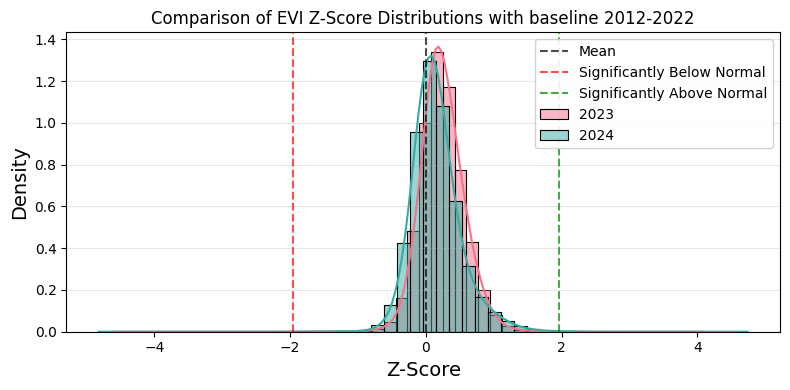

In [43]:
plot_zscore_histograms('../../docs/images/agriculture/evi_zscore_2023.tif',
                        '../../docs/images/agriculture/evi_zscore_2024.tif',
                          
                          labels =['2023', '2024'],
                          baseline_years = '2012-2022')


Statistical Summary:
--------------------------------------------------------------------------------
File                                           Mean     Median        Std     -1.96%     +1.96%
--------------------------------------------------------------------------------
2023                                          0.236      0.210      0.366        0.0        0.1
2024                                          0.143      0.096      0.432        0.0        0.2
--------------------------------------------------------------------------------


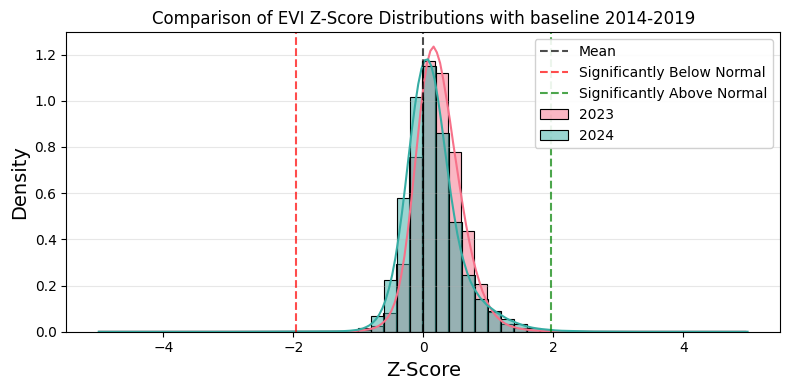

In [45]:
plot_zscore_histograms('../../docs/images/agriculture/evi_zscore_2014_2019_2023.tif',
                        '../../docs/images/agriculture//evi_zscore_2014_2019_2024.tif',
                          
                          labels =['2023', '2024'],
                          baseline_years = '2014-2019')

In [78]:
import geopandas as gpd
import numpy as np
from rasterstats import zonal_stats

def aggregate_zscores(raster_path, adm1):
    """Aggregate pixel Z-scores to ADM1 regions"""
    # Load admin boundaries
    #adm1 = gpd.read_file(adm1_path)
    
    # Calculate zonal statistics
    stats = zonal_stats(
        adm1,
        raster_path,
        stats=['mean', 'median', 'min', 'max', 'std', 'count'],
        geojson_out=True
    )
    
    # Convert to GeoDataFrame
    result = gpd.GeoDataFrame.from_features(stats)
    
    # Add original attributes
    for col in ['ADM1_EN']:
        if col in adm1.columns:
            result[col] = adm1[col].values
    
    return result

def plot_zscore_maps(gdfs, stat='mean', titles=None, figsize_per_plot=(8, 4), main_title='EVI Z-Score'):
    """
    Plot aggregated Z-scores by region for multiple GeoDataFrames
    
    Parameters:
    gdfs: List of GeoDataFrames to plot
    stat: Single statistic to plot for each GDF (default 'mean')
    titles: Optional list of titles for each plot (default None)
    figsize_per_plot: Size of each individual plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # If gdfs is not a list, convert it to one
    if not isinstance(gdfs, list):
        gdfs = [gdfs]
    
    # Calculate number of plots and grid dimensions
    n_plots = len(gdfs)
    
    # Calculate grid layout
    if n_plots == 1:
        nrows, ncols = 1, 1
    elif n_plots == 2:
        nrows, ncols = 1, 2
    elif n_plots <= 4:
        nrows, ncols = 2, 2
    elif n_plots <= 6:
        nrows, ncols = 2, 3
    else:
        # For more than 6, use a 3 column layout
        ncols = 3
        nrows = int(np.ceil(n_plots / ncols))
    
    # Create figure with appropriate size
    width = figsize_per_plot[0] * ncols
    height = figsize_per_plot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(width, height))
    
    # Handle case where axes is not a 2D array
    if n_plots == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = axes.reshape(nrows, ncols)
    
    # Generate default titles if none provided
    if titles is None:
        titles = [f'EVI Z-Score by Region {i+1}' for i in range(n_plots)]
    elif len(titles) < n_plots:
        # Extend titles list if needed
        titles.extend([f'EVI Z-Score by Region {i+1}' for i in range(len(titles), n_plots)])
    
    # Plot each GeoDataFrame
    for idx, gdf in enumerate(gdfs):
        row_idx = idx // ncols
        col_idx = idx % ncols
        ax = axes[row_idx, col_idx]
        
        if stat in gdf.columns:
            gdf.plot(column=stat, cmap='BrBG', linewidth=0.5, 
                    edgecolor='0.5', legend=True, ax=ax, vmin=-2, vmax=2)
            ax.set_title(titles[idx])
        else:
            # If stat not found, show empty plot with message
            ax.text(0.5, 0.5, f'"{stat}" not found in GDF {idx+1}', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title(f'Missing: {stat} in {titles[idx]}')
        
        ax.set_axis_off()
    
    # Remove any unused subplots
    for idx in range(n_plots, nrows * ncols):
        row_idx = idx // ncols
        col_idx = idx % ncols
        fig.delaxes(axes[row_idx, col_idx])

    plt.suptitle(main_title, fontsize=16, weight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

In [46]:
zscore_gdf_adm1 = []
zscore_gdf_adm2 = []

for year in range(2019, 2025):
    zscore_gdf = aggregate_zscores(f'../../docs/images/agriculture/evi_zscore_2014_2019_{year}.tif', eth_adm1)
    zscore_gdf_adm1.append(zscore_gdf)

for year in range(2019, 2025):
    zscore_gdf = aggregate_zscores(f'../../docs/images/agriculture/evi_zscore_2014_2019_{year}.tif', eth_adm2)
    zscore_gdf_adm2.append(zscore_gdf)
#fig = plot_zscore_maps(zscore_gdfs, titles = [2019,2020,2021,2022,2023,2024], main_title='EVI Z-Score by Region compared to 10y baseline (2012-2022)')


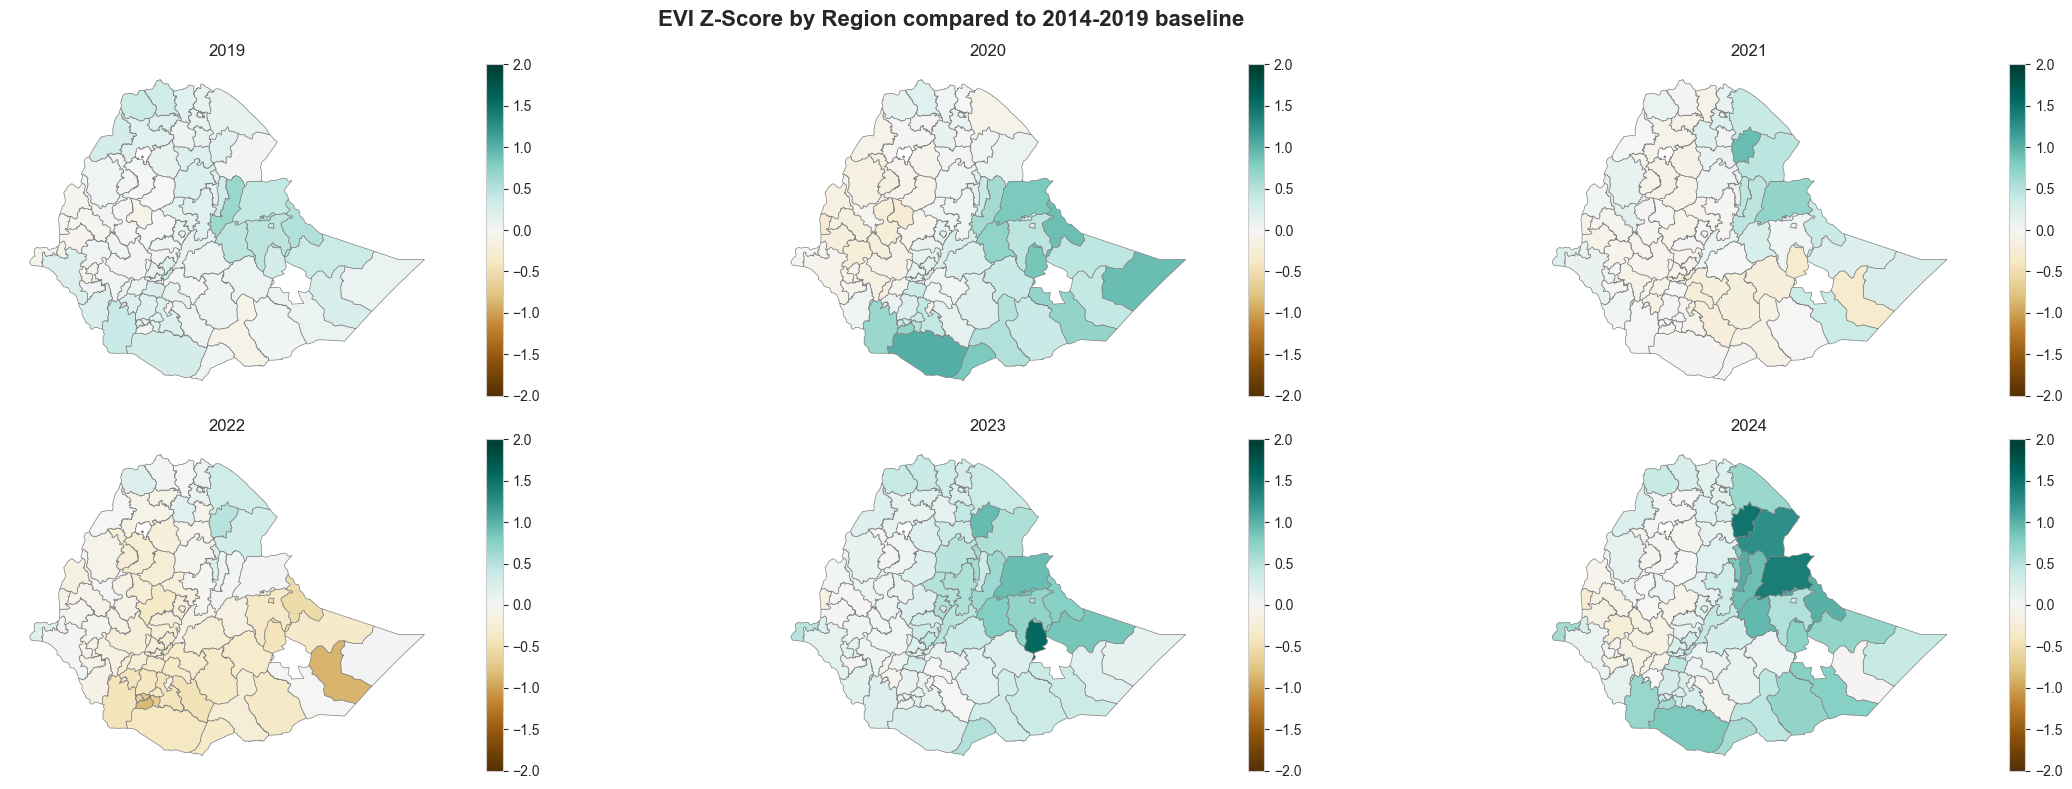

In [79]:
fig = plot_zscore_maps(zscore_gdf_adm2, titles = [2019,2020,2021,2022,2023,2024], main_title='EVI Z-Score by Region compared to 2014-2019 baseline')


In [47]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LinearSegmentedColormap

def read_tif_files(pattern='../../docs/images/agriculture/evi_zscore_*.tif'):
    """
    Read all TIF files matching the pattern and return a dictionary
    with year as key and array data as value
    """
    files = sorted(glob.glob(pattern))
    data_dict = {}
    
    for file in files:
        # Extract year from filename
        year = file.split('_')[-1].split('.')[0]
        
        # Read the raster file
        with rasterio.open(file) as src:
            data = src.read(1)  # Read first band
            
            # Handle NoData values
            if src.nodata is not None:
                mask = data != src.nodata
                valid_data = data[mask]
            else:
                valid_data = data[~np.isnan(data)]
            
            data_dict[int(year)] = valid_data
    
    return data_dict

def calculate_zscore_percentages(data_dict):
    """
    Calculate the percentage of area in each Z-score bin for each year
    """
    # Define Z-score bins
    bins = [float('-inf'), -2, -1, -0.5, 0.5, 1, 2, float('inf')]
    bin_labels = ['< -2', '(-2, -1]', '(-1, -0.5]', '(-0.5, 0.5]', 
                  '(0.5, 1]', '(1, 2]', '> 2']
    
    results = {}
    
    for year, zscores in data_dict.items():
        # Calculate percentages for each bin
        percentages = []
        total_count = len(zscores)
        
        for i in range(len(bins) - 1):
            if i == 0:  # First bin (< -2)
                count = np.sum(zscores < bins[i+1])
            elif i == len(bins) - 2:  # Last bin (> 2)
                count = np.sum(zscores > bins[i])
            else:  # Middle bins
                count = np.sum((zscores > bins[i]) & (zscores <= bins[i+1]))
            
            percentage = (count / total_count) * 100 if total_count > 0 else 0
            percentages.append(percentage)
        
        results[year] = percentages
    
    return results, bin_labels

def plot_productivity_anomalies(data_dict, title="Anomalies in Agricultural Productivity (EVI)"):
    """
    Create a stacked bar chart showing Z-score percentages by year
    """
    results, bin_labels = calculate_zscore_percentages(data_dict)
    
    # Convert to DataFrame
    df = pd.DataFrame(results, index=bin_labels).T
    df.sort_index(inplace=True)
    
    # Define colors for each Z-score range
    colors = ['#8B4513', '#CD853F', '#DEB887', '#E0F5F5', '#48D1CC', '#008B8B', '#006400']
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create stacked horizontal bars
    bars = ax.barh(df.index.astype(str), df.iloc[:, 0], color=colors[0], label=bin_labels[0])
    
    for i in range(1, len(bin_labels)):
        ax.barh(df.index.astype(str), df.iloc[:, i], 
                left=df.iloc[:, :i].sum(axis=1), 
                color=colors[i], label=bin_labels[i])
    
    # Set labels and title
    ax.set_xlabel('% of Crop Area', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Set x-axis limits and format
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    # Add grid
    ax.grid(axis='x', alpha=0.3)
    
    # Create custom legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), 
              title='Z-Score', fontsize=10)
    
    # Add source text
    plt.figtext(0.99, 0.02, 'Source: MODIS Terra and Aqua', ha='right', va='bottom', 
                fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    
    return fig, ax

Loaded data for years: [2019, 2020, 2021, 2022, 2023, 2024]


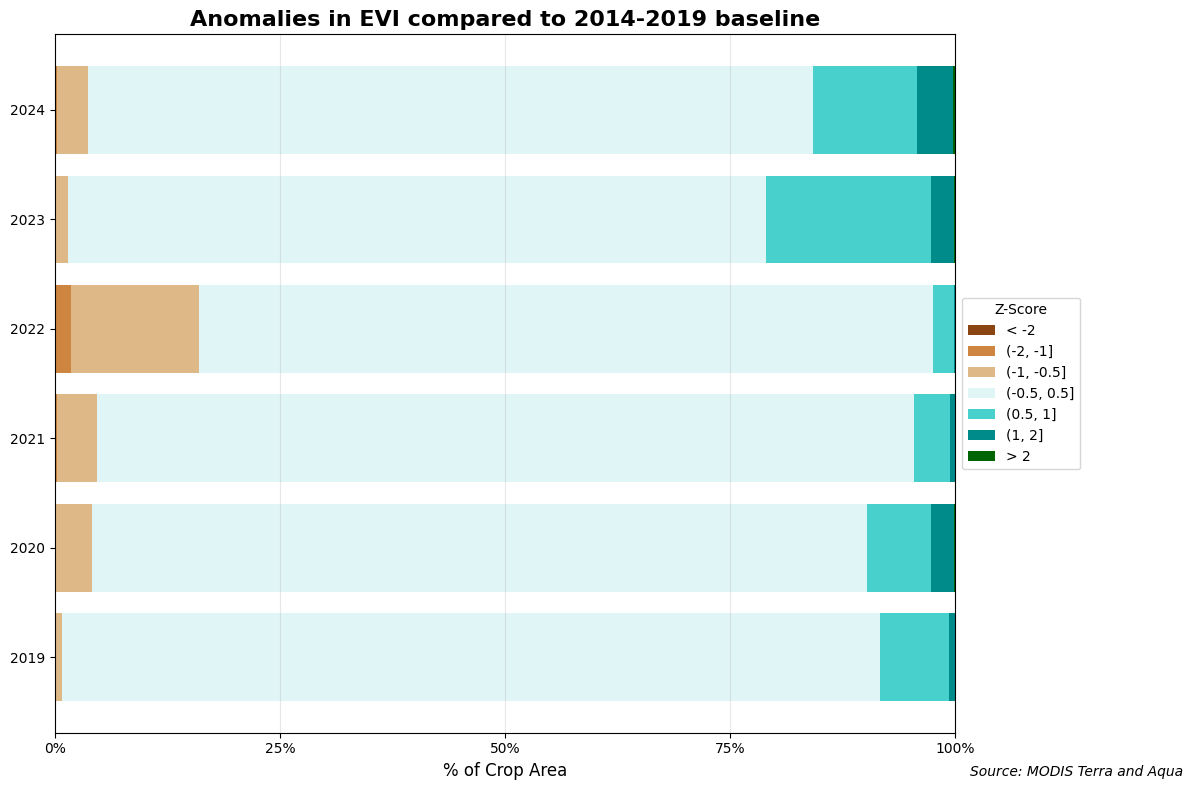

In [50]:

# Read all TIF files
data_dict = read_tif_files('../../docs/images/agriculture/evi_zscore_2014_2019_*.tif')

# Check if data was loaded
if not data_dict:
    print("No TIF files found. Make sure the files are in the current directory.")
    print("Files should be named like: evi_zscore_2014.tif, evi_zscore_2015.tif, etc.")
else:
    print(f"Loaded data for years: {sorted(data_dict.keys())}")
    
    # Create the plot
    fig, ax = plot_productivity_anomalies(data_dict, title = 'Anomalies in EVI compared to 2014-2019 baseline')
    
    # Save the plot
    plt.savefig('../../docs/images/agriculture/agricultural_productivity_anomalies_2014_2019_baseline.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

### Trends in Median EVI

In [ ]:
# Filter to reduce data volume (e.g., just get one composite per month)
for year in range(2012, 2025):

    filtered_mxd13q1 = mxd13q1.filter(
            ee.Filter.calendarRange(year, year, 'year')
        )

    zs = ZonalStats(
        ee_dataset=filtered_mxd13q1,
        target_features=eth_adm0,
        statistic_type="median",
        scale=250,
        output_name=f"eth_evi_adm0_median_{year}",
        output_dir="GEE_ETH",
        scale_factor=0.0001,
        tile_scale=4
    )

    zs.runZonalStats()


In [92]:
# Get all unique admin regions
all_admin_regions = list(eth_adm2['ADM2_EN'].unique())
batch_size = 3  # Process 3 regions at a time
total_regions = len(all_admin_regions)

print(f"Total admin regions: {total_regions}")
print(f"Will process in batches of {batch_size}")

# Loop through admin regions in batches
for batch_idx in range(0, total_regions, batch_size):
    batch_end = min(batch_idx + batch_size, total_regions)
    batch_regions = all_admin_regions[batch_idx:batch_end]
    batch_num = (batch_idx // batch_size) + 1
    
    print(f"\nProcessing batch {batch_num}: {batch_regions}")
    
    # Loop through years
    for year in range(2019, 2025):
        
        filtered_mxd13q1 = mxd13q1.filter(
            ee.Filter.calendarRange(year, year, 'year')
        )
        
        # Create descriptive filename with region names
        region_names = "_".join([name.replace(" ", "").replace(",", "")[:8] for name in batch_regions])
        output_name = f"eth_evi_adm2_median_{year}_batch{batch_num:02d}_{region_names}"
        
        try:
            zs = ZonalStats(
                ee_dataset=filtered_mxd13q1,
                target_features=eth_adm2[eth_adm2['ADM2_EN'].isin(batch_regions)],
                statistic_type="median",
                scale=250,
                output_name=output_name,
                output_dir="GEE_ETH",
                scale_factor=0.0001,
                tile_scale=4
            )
            
            zs.runZonalStats()
            print(f"  ✓ Year {year} batch {batch_num} submitted: {output_name}")
            
        except Exception as e:
            print(f"  ✗ Error with year {year} batch {batch_num}: {str(e)}")

print(f"\nCompleted processing all batches!")

# Optional: Print what files to expect
print(f"\nExpected output files:")
for batch_idx in range(0, total_regions, batch_size):
    batch_regions = all_admin_regions[batch_idx:batch_idx + batch_size]
    batch_num = (batch_idx // batch_size) + 1
    region_names = "_".join([name.replace(" ", "").replace(",", "")[:8] for name in batch_regions])
    for year in range(2024, 2025):
        print(f"  - eth_evi_adm2_median_{year}_batch{batch_num:02d}_{region_names}.csv")

Total admin regions: 92
Will process in batches of 3

Processing batch 1: ['Afder', 'Agnewak', 'Alle']
  ✓ Year 2019 batch 1 submitted: eth_evi_adm2_median_2019_batch01_Afder_Agnewak_Alle
  ✓ Year 2020 batch 1 submitted: eth_evi_adm2_median_2020_batch01_Afder_Agnewak_Alle
  ✓ Year 2021 batch 1 submitted: eth_evi_adm2_median_2021_batch01_Afder_Agnewak_Alle
  ✓ Year 2022 batch 1 submitted: eth_evi_adm2_median_2022_batch01_Afder_Agnewak_Alle
  ✓ Year 2023 batch 1 submitted: eth_evi_adm2_median_2023_batch01_Afder_Agnewak_Alle
  ✓ Year 2024 batch 1 submitted: eth_evi_adm2_median_2024_batch01_Afder_Agnewak_Alle

Processing batch 2: ['Amaro', 'Arsi', 'Assosa']
  ✓ Year 2019 batch 2 submitted: eth_evi_adm2_median_2019_batch02_Amaro_Arsi_Assosa
  ✓ Year 2020 batch 2 submitted: eth_evi_adm2_median_2020_batch02_Amaro_Arsi_Assosa
  ✓ Year 2021 batch 2 submitted: eth_evi_adm2_median_2021_batch02_Amaro_Arsi_Assosa
  ✓ Year 2022 batch 2 submitted: eth_evi_adm2_median_2022_batch02_Amaro_Arsi_Assosa
  

In [96]:
# Filter to reduce data volume (e.g., just get one composite per month)
for year in range(2012, 2018):

    filtered_mxd13q1 = mxd13q1.filter(
            ee.Filter.calendarRange(year, year, 'year')
        )

    zs = ZonalStats(
        ee_dataset=filtered_mxd13q1,
        target_features=eth_adm1,
        statistic_type="median",
        scale=250,
        output_name=f"eth_evi_adm1_median_{year}",
        output_dir="GEE_ETH",
        scale_factor=0.0001,
        tile_scale=4
    )

    zs.runZonalStats()


In [98]:
import glob
import os
import pandas as pd

def process_evi_files(input_dir, output_dir, evi_files):
    
    # List to hold all transformed dataframes
    all_transformed_data = []
    
    # Track which admin level we're processing
    admin_level = None

    for file_path in evi_files:
        print(f"Processing {os.path.basename(file_path)}...")
        
        try:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Create an empty list to hold the transformed rows
            transformed_data = []
            
            # Identify EVI columns (those ending with _EVI)
            evi_columns = [col for col in df.columns if col.endswith('_EVI')]
            
            # Identify shape/geography columns - look for both ADM0_EN and ADM1_EN
            shape_columns = ['system:index', 'ADM0_EN', 'ADM1_EN', 'ADM0_PCODE', 'ADM0ALT1EN', 'ADM0ALT2EN', 
                            'ADM0_REF', 'Shape_Area', 'Shape_Leng', 'validOn', 'validTo', 'ADM2_EN']
            # Keep only columns that exist in the dataframe
            shape_columns = [col for col in shape_columns if col in df.columns]
            
            # Determine admin level for this file
            if 'ADM2_EN' in df.columns:
                admin_level = 'adm2'
            elif 'ADM1_EN' in df.columns:
                admin_level = 'adm1'
            elif 'ADM0_EN' in df.columns:
                admin_level = 'adm0'
            else:
                admin_level = 'unknown'
                print(f"Warning: Could not determine admin level for {file_path}")
            
            # For each row in the original dataframe
            for _, row in df.iterrows():
                # Get admin area based on detected level
                if admin_level == 'adm1' and pd.notna(row['ADM1_EN']):
                    admin_area = row['ADM1_EN']
                elif admin_level == 'adm0' and pd.notna(row['ADM0_EN']):
                    admin_area = row['ADM0_EN']
                elif admin_level == 'adm2' and pd.notna(row['ADM2_EN']):
                    admin_area = row['ADM2_EN']
                else:
                    # If neither exists, use a default or skip
                    admin_area = "Unknown"
                
                # For each EVI column, create a new row with date information
                for evi_col in evi_columns:
                    # Extract date components from column name
                    # Format is typically like "1_2012_06_09_EVI"
                    try:
                        parts = evi_col.split('_')
                        collection = parts[0]
                        date_year = parts[1]
                        date_month = parts[2]
                        date_day = parts[3]
                        
                        # Create a date string
                        date_str = f"{date_year}-{date_month}-{date_day}"
                        
                        # Create a row for the transformed data
                        new_row = {
                            'date': date_str,
                            'admin_area': admin_area,
                            'admin_level': admin_level,
                            'collection': collection,
                            'evi_value': row[evi_col]
                        }
                        
                        # Add all shape columns (except '.geo' which can cause issues)
                        for shape_col in shape_columns:
                            if shape_col in row and shape_col != '.geo':
                                new_row[shape_col] = row[shape_col]
                        
                        transformed_data.append(new_row)
                    except (IndexError, ValueError) as e:
                        print(f"Error processing column {evi_col}: {e}")
            
            # Create a dataframe from the transformed data
            if transformed_data:
                transformed_df = pd.DataFrame(transformed_data)
                all_transformed_data.append(transformed_df)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Combine all transformed dataframes
    if all_transformed_data:
        combined_df = pd.concat(all_transformed_data, ignore_index=True)
        
        # Convert date to datetime for proper sorting
        combined_df['date'] = pd.to_datetime(combined_df['date'])
        
        # Group data by admin level
        admin_levels = combined_df['admin_level'].unique()
        
        for level in admin_levels:
            level_df = combined_df[combined_df['admin_level'] == level]
            
            # Sort by admin area and date
            level_df = level_df.sort_values(['admin_area', 'date'])
            
            # Save the combined data to a single file with admin level in the name
            combined_file = os.path.join(output_dir, f"eth_evi_all_years_combined_{level}.csv")
            level_df.to_csv(combined_file, index=False)
            print(f"Saved combined data to {combined_file}")
            
            # Optional: Create monthly and yearly summaries with admin level in the name
            monthly_summary = level_df.groupby(['admin_area', pd.Grouper(key='date', freq='MS')])['evi_value'].agg(['mean', 'min', 'max', 'count']).reset_index()
            monthly_file = os.path.join(output_dir, f"eth_evi_monthly_summary_{level}.csv")
            monthly_summary.to_csv(monthly_file, index=False)
            print(f"Saved monthly summary to {monthly_file}")
            
            yearly_summary = level_df.groupby(['admin_area', pd.Grouper(key='date', freq='YS')])['evi_value'].agg(['mean', 'min', 'max', 'count']).reset_index()
            yearly_file = os.path.join(output_dir, f"eth_evi_yearly_summary_{level}.csv")
            yearly_summary.to_csv(yearly_file, index=False)
            print(f"Saved yearly summary to {yearly_file}")
    else:
        print("No data was processed successfully")

    print("Processing complete!")

In [99]:
import glob
input_dir = '../../data/agriculture/raw/admin2/'
output_dir = '../../data/agriculture/processed/'

evi_files = glob.glob(os.path.join(input_dir, "eth_evi_adm2_median_*.csv"))

process_evi_files(input_dir, output_dir, evi_files)

Processing eth_evi_adm2_median_2019_batch01_Afder_Agnewak_Alle.csv...
Processing eth_evi_adm2_median_2019_batch02_Amaro_Arsi_Assosa.csv...
Processing eth_evi_adm2_median_2019_batch03_Awi_Awsi_Zon_Bale.csv...
Processing eth_evi_adm2_median_2019_batch04_Basketo_BenchShe_Borena.csv...
Processing eth_evi_adm2_median_2019_batch05_BunoBede_Burji_Central.csv...
Processing eth_evi_adm2_median_2019_batch06_CentralG_Daawa_Dawuro.csv...
Processing eth_evi_adm2_median_2019_batch07_Derashe_DireDawa_DireDawa.csv...
Processing eth_evi_adm2_median_2019_batch08_Doolo_EastBale_EastGoja.csv...
Processing eth_evi_adm2_median_2019_batch09_EastHara_EastShew_EastWell.csv...
Processing eth_evi_adm2_median_2019_batch10_Eastern_Erer_Fafan.csv...
Processing eth_evi_adm2_median_2019_batch11_Fanti_Zo_FinfineS_Gabi_Zon.csv...
Processing eth_evi_adm2_median_2019_batch12_Gamo_Gedeo_Gofa.csv...
Processing eth_evi_adm2_median_2019_batch13_Guji_Guraghe_Hadiya.csv...
Processing eth_evi_adm2_median_2019_batch14_Halaba_Har

In [53]:
import glob
input_dir = '../../data/agriculture/raw/'
output_dir = '../../data/agriculture/processed/'

evi_files = glob.glob(os.path.join(input_dir, "eth_evi_adm1_median_*.csv"))

process_evi_files(input_dir, output_dir, evi_files)

Processing eth_evi_adm1_median_2012.csv...
Processing eth_evi_adm1_median_2013.csv...
Processing eth_evi_adm1_median_2014.csv...
Processing eth_evi_adm1_median_2015.csv...
Processing eth_evi_adm1_median_2016.csv...
Processing eth_evi_adm1_median_2017.csv...
Processing eth_evi_adm1_median_2019.csv...
Processing eth_evi_adm1_median_2020.csv...
Processing eth_evi_adm1_median_2021.csv...
Processing eth_evi_adm1_median_2022.csv...
Processing eth_evi_adm1_median_2023.csv...
Processing eth_evi_adm1_median_2024.csv...
Saved combined data to ../../data/agriculture/processed/eth_evi_all_years_combined_adm1.csv
Saved monthly summary to ../../data/agriculture/processed/eth_evi_monthly_summary_adm1.csv
Saved yearly summary to ../../data/agriculture/processed/eth_evi_yearly_summary_adm1.csv
Processing complete!


In [ ]:
evi_median = pd.read_csv('../../data/agriculture/processed/eth_evi_monthly_summary_adm1.csv')
evi_median.rename(columns={"mean": "median"}, inplace=True)
#evi_median['admin_area'] = evi_median['admin_area'].apply(lambda x: x.encode('latin1').decode('utf-8') if 'Ã' in x else x)

evi_median_adm0 = pd.read_csv('../../data/agriculture/processed/eth_evi_monthly_summary_adm0.csv')
evi_median_adm0.rename(columns={"mean": "median"}, inplace=True)

In [100]:
evi_median_adm2 = pd.read_csv('../../data/agriculture/processed/eth_evi_monthly_summary_adm2.csv')
evi_median_adm2.rename(columns={"mean": "median"}, inplace=True)

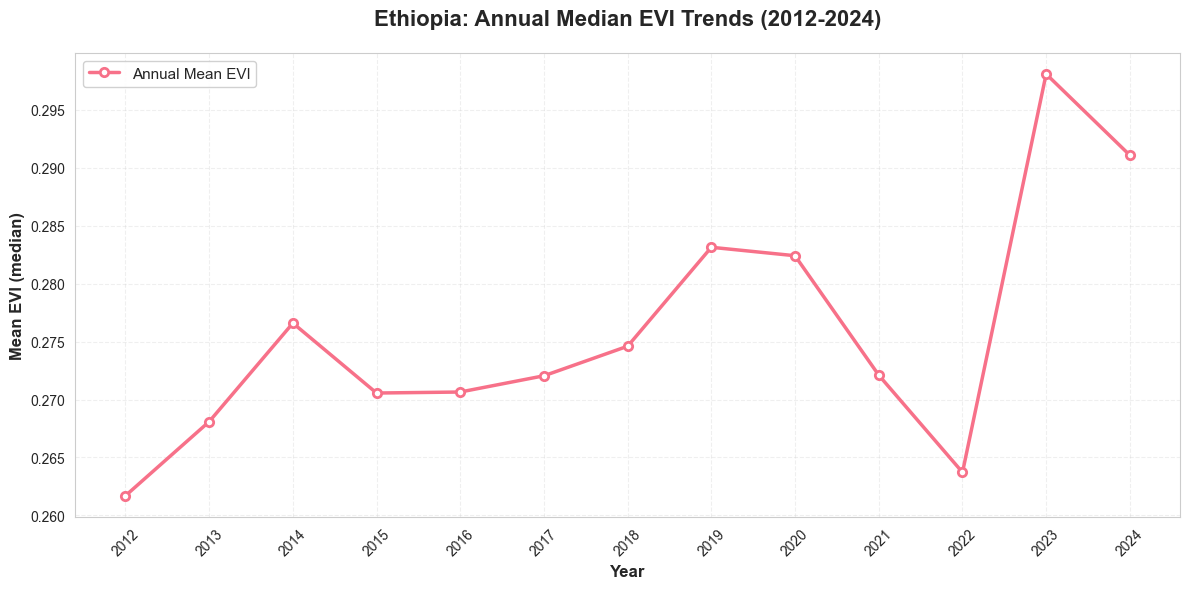

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data
evi_median_yearly = pd.read_csv('../../data/agriculture/processed/eth_evi_yearly_summary_adm0.csv')
#evi_median_yearly = evi_median_yearly[evi_median_yearly['date']>'2018-01-01']

# Create figure with custom size
plt.figure(figsize=(12, 6))

# Set style
sns.set_style("whitegrid", {"grid.alpha": 0.3})
sns.set_palette("husl")

# Convert date to datetime and set as index
evi_median_yearly['date'] = pd.to_datetime(evi_median_yearly['date'])
evi_median_yearly_indexed = evi_median_yearly.set_index('date')

# Plot with enhanced styling
line = plt.plot(evi_median_yearly_indexed.index, 
                evi_median_yearly_indexed['mean'], 
                linewidth=2.5, 
                marker='o', 
                markersize=6,
                markerfacecolor='white',
                markeredgewidth=2,
                label='Annual Mean EVI')

# Add a subtle fill under the line
# plt.fill_between(evi_median_yearly_indexed.index, 
#                 evi_median_yearly_indexed['mean'], 
#                 alpha=0.1, 
#                 color=line[0].get_color())

# Customize the plot
plt.title('Ethiopia: Annual Median EVI Trends (2012-2024)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Mean EVI (median)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', frameon=True, framealpha=0.9, fontsize=11)

# Format x-axis dates
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Add subtle trend line (optional)
# from scipy import stats
# x = range(len(evi_median_yearly_indexed))
# slope, intercept, r_value, p_value, std_err = stats.linregress(x, evi_median_yearly_indexed['mean'])
# line_fitted = [intercept + slope * i for i in x]
# plt.plot(evi_median_yearly_indexed.index, line_fitted, 'k--', alpha=0.5, linewidth=1, label=f'Trend (R² = {r_value**2:.3f})')
# plt.legend(loc='best', frameon=True, framealpha=0.9, fontsize=11)
# plt.annotate('Event name', xy=(2018, 0.4), xytext=(2017, 0.45),
#              arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
#              fontsize=10, color='red')
# Adjust layout
plt.tight_layout()

# Optional: Add annotation for significant events


# Show the plot
plt.show()


**There is an increasing trend in EVI in Ethiopia since 2012.** However, the dip during the Tigray war and now during the Amhara war is evident. 

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def get_trend_plot(evi_median, crop_admin_regions, title, show_trend=False, max_cols=3, column='median'):
    """
    Create EVI time series plots by admin area in a dynamic grid layout with optional trend lines.
    
    Parameters:
    - evi_median: DataFrame with columns 'admin_area', 'date', and 'median'
    - crop_admin_regions: List of admin areas to include in the plot
    - title: Plot title
    - show_trend: Boolean indicating whether to show trend lines
    - max_cols: Maximum number of columns in the grid (default: 3)
    
    Returns:
    - fig: The matplotlib figure object
    """
    # Convert date to datetime
    evi_median['date'] = pd.to_datetime(evi_median['date'])

    # Get unique admin areas
    admin_areas = crop_admin_regions
    n_areas = len(admin_areas)
    
    # Calculate grid dimensions
    n_cols = min(max_cols, n_areas)
    n_rows = (n_areas + n_cols - 1) // n_cols  # Ceiling division
    
    # Calculate figure size based on grid
    fig_width = 4 * n_cols
    fig_height = 3 * n_rows
    
    # Create figure and subplots in grid layout
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), 
                            sharex=True, sharey=True)
    fig.suptitle(title, fontsize=16, y=0.98)
    
    # Flatten axes array for easier indexing
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Add EVI label on the left side
    fig.text(0.02, 0.5, 'EVI', va='center', rotation='vertical', fontsize=14, weight='bold')
    
    # Plot each admin area in its own subplot
    for i, area in enumerate(admin_areas):
        ax = axes[i]
        
        # Filter data for this admin area and sort by date
        area_data = evi_median[evi_median['admin_area'] == area].sort_values('date')
        
        # Plot the data
        ax.plot(area_data['date'], area_data[column], color='green', linewidth=1.5, alpha=0.8)
        
        # Add trend line if requested
        if show_trend and len(area_data) > 1:
            add_trend_line(ax, area_data['date'].values, area_data[column].values)
        
        # Add area name as title
        ax.set_title(area, fontsize=11, weight='bold', pad=10)
        
        # Add gridlines
        ax.grid(True, linestyle='-', linewidth=0.3, alpha=0.7)
        
        # Clean up spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Format ticks
        ax.tick_params(axis='both', labelsize=9)
        
        # Format x-axis for bottom row
        row = i // n_cols
        if row == n_rows - 1:  # Bottom row
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.tick_params(axis='x', rotation=45)
        
        # Format y-axis for leftmost column
        col = i % n_cols
        if col == 0:  # Leftmost column
            ax.yaxis.set_ticks_position('left')
    
    # Hide unused subplots
    for i in range(n_areas, len(axes)):
        axes[i].set_visible(False)
    
    # Add source note
    fig.text(0.98, 0.01, 'Source: MODIS Processed', ha='right', fontsize=9, style='italic')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(left=0.06, bottom=0.08, top=0.92, hspace=0.3, wspace=0.2)
    
    return fig

def add_trend_line(ax, dates, values):
    """
    Add a trend line to the plot using linear regression.
    
    Parameters:
    - ax: matplotlib axis object
    - dates: array of datetime objects
    - values: array of EVI values
    """
    # Convert dates to numeric values for regression
    dates_numeric = mdates.date2num(dates)
    
    # Perform linear regression
    coefficients = np.polyfit(dates_numeric, values, 1)
    trend_line = np.poly1d(coefficients)
    
    # Plot trend line
    ax.plot(dates, trend_line(dates_numeric), color='red', linestyle='--', 
            linewidth=2, alpha=0.8, label='Trend')
    
    # Add legend for trend line
    ax.legend(loc='upper right', fontsize=8, framealpha=0.8)

In [111]:
evi_median_annual_adm1 = pd.read_csv('../../data/agriculture/processed/eth_evi_yearly_summary_adm1.csv')
evi_median_annual_adm1.rename(columns={"mean": "median"}, inplace=True)

evi_median_monthly_adm1 = pd.read_csv('../../data/agriculture/processed/eth_evi_monthly_summary_adm1.csv')
evi_median_monthly_adm1.rename(columns={"mean": "median"}, inplace=True)

In [122]:
import numpy as np

def get_annual_percent_change(df, group_columns=['ADM1_EN'], baseline_year='PY', column='ntl_sum'):
    df = df.copy()
    df['year'] = df['date'].dt.year
    baseline_column = f'baseline_{column}_{baseline_year}'
    column_name = f'percent_change_{column}_{baseline_year}'

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute annual baseline NO2 for the specified baseline year
        
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby(group_columns)[column]
            .mean()
            .reset_index()
            .rename(columns={column: baseline_column})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=group_columns, how='left')    

    # Compute the annual percentage change
        df[column_name] = np.where(
    df[baseline_column] == 0,  # Check if baseline value is zero
    np.nan,  # Assign NaN (or use 0 if preferred)
    ((df[column] - df[baseline_column]) / df[baseline_column]) * 100
)


    elif baseline_year == 'PY':  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's annual baseline
            
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby(group_columns)[column]
                .mean()
                .reset_index()
                .rename(columns= {column:baseline_column})
            )
            

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, baseline_column] = df.loc[df['year'] == year, group_columns].merge(
                baseline_df, on=group_columns, how='left'
            )[baseline_column].values


            df[column_name] = np.where(
    df[baseline_column] == 0,  # Check if baseline value is zero
    np.nan,  # Assign NaN (or use 0 if preferred)
    ((df[column] - df[baseline_column]) / df[baseline_column]) * 100
)


    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")
    
    

    return df


In [134]:
evi_median_annual_adm1 = get_annual_percent_change(evi_median_annual_adm1, group_columns=['admin_area'], baseline_year='PY', column='median')
evi_median_annual_adm1 = get_annual_percent_change(evi_median_annual_adm1, group_columns=['admin_area'], baseline_year=2023, column='median')

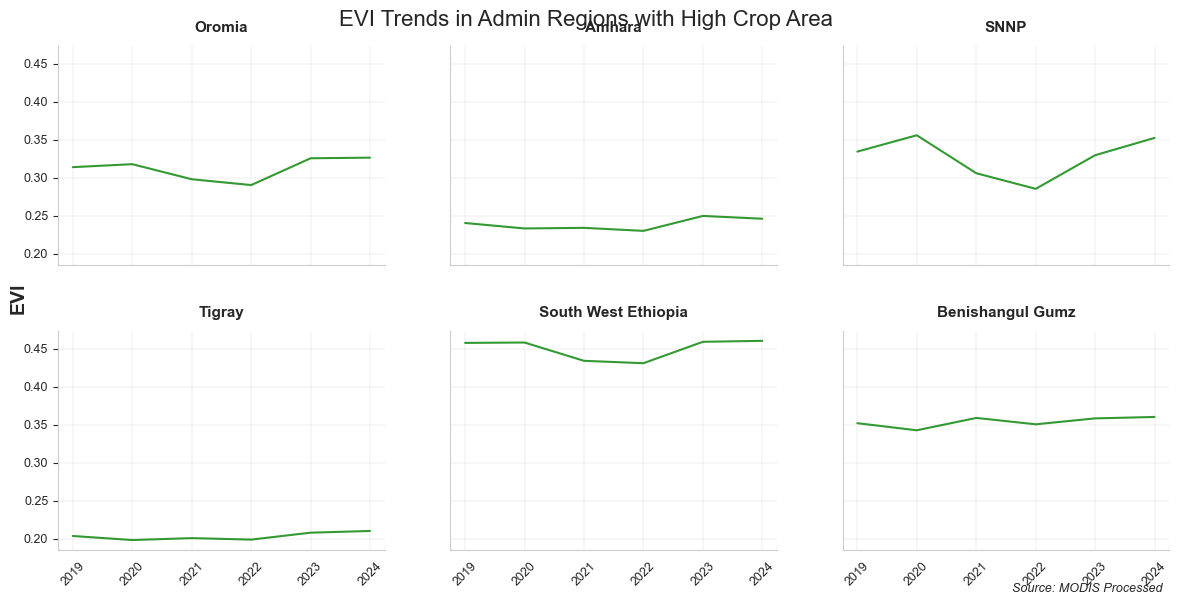

In [114]:
fig = get_trend_plot(evi_median_annual_adm1, crop_admin_regions, 'EVI Trends in Admin Regions with High Crop Area', show_trend=False)

C:\Users\wb588851\AppData\Local\Temp\ipykernel_29712\962424553.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)


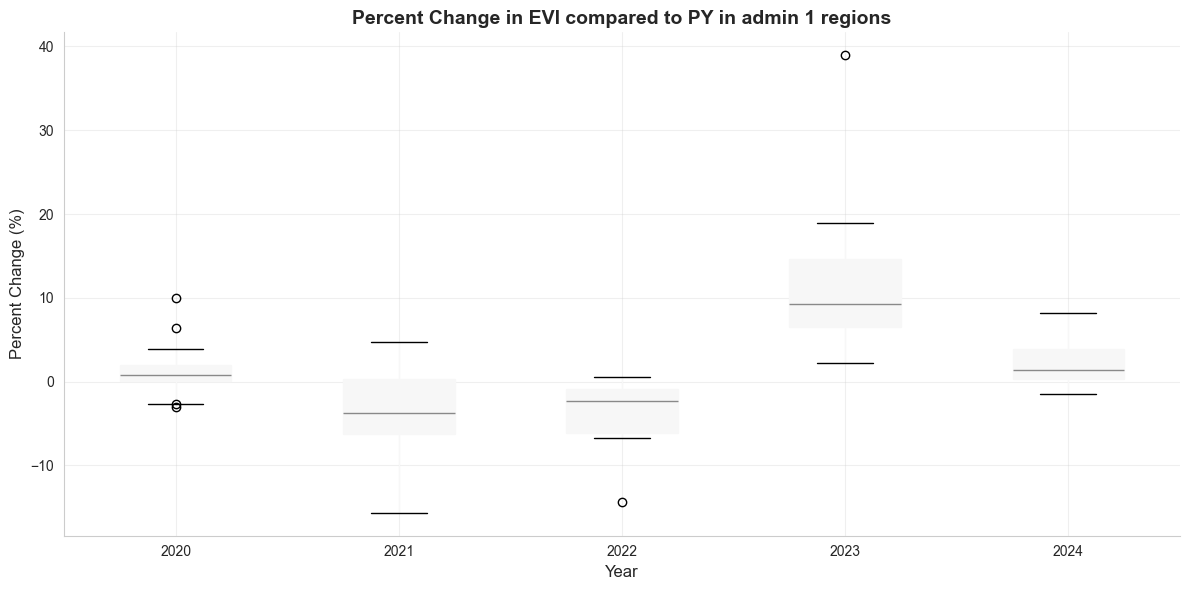

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_simple_boxplot(df, title="Percent Change in EVI compared to PY in admin 1 regions"):
    """
    Create a simple boxplot of percent_change_median_PY values by year.
    
    Parameters:
    - df: DataFrame containing the EVI data
    - title: Plot title
    
    Returns:
    - fig: The matplotlib figure object
    """
    # Create the boxplot similar to your example
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare data - pivot to have years as columns for boxplot
    boxplot_data = df.pivot_table(
        index='admin_area', 
        columns='year', 
        values='percent_change_median_PY'
    ).fillna(0)
    
    # Create boxplot
    boxplot_data.boxplot(ax=ax, patch_artist=True)
    
    # Customize the plot
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Percent Change (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add zero reference line
    #ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig



# One-liner equivalent to your example:
# df[['percent_change_median_PY', 'year']].set_index('year').fillna(0).boxplot()

# Example usage:
fig = create_simple_boxplot(evi_median_annual_adm1)
#fig = create_boxplot_by_year(evi_median_annual_adm1)

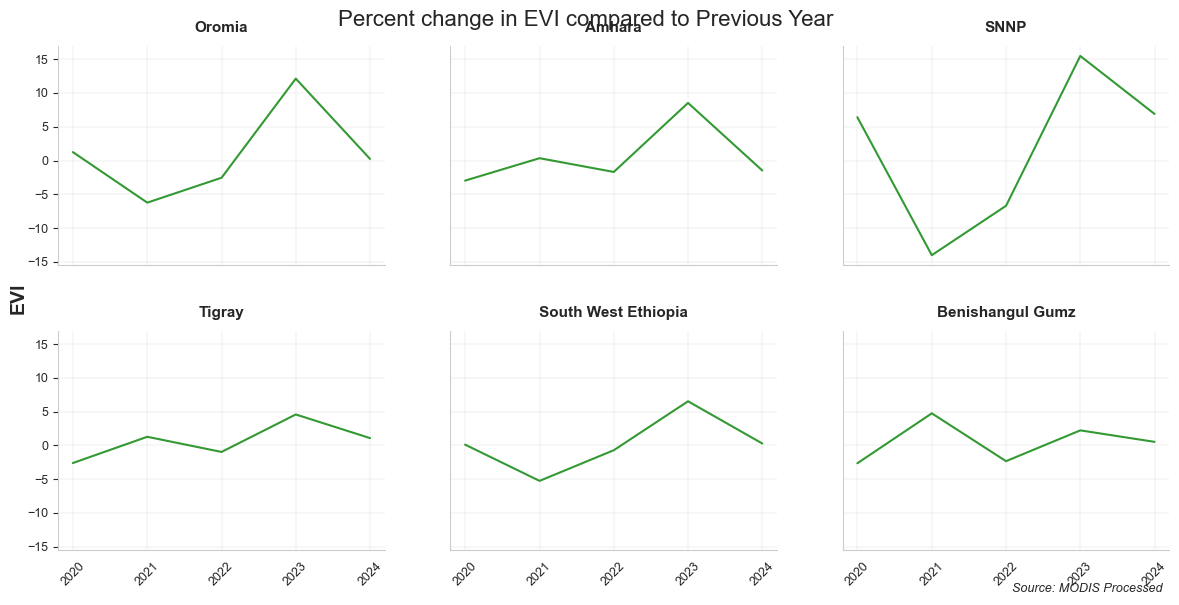

In [138]:
fig = get_trend_plot(evi_median_annual_adm1, crop_admin_regions, 'Percent change in EVI compared to Previous Year', show_trend=False, column='percent_change_median_PY')

In [101]:
evi_median_annual_adm2 = pd.read_csv('../../data/agriculture/processed/eth_evi_yearly_summary_adm2.csv')
evi_median_annual_adm2.rename(columns={"mean": "median"}, inplace=True)

evi_median_monthly_adm2 = pd.read_csv('../../data/agriculture/processed/eth_evi_monthly_summary_adm2.csv')
evi_median_monthly_adm2.rename(columns={"mean": "median"}, inplace=True)

In [116]:
crop_admin2_regions = eth_adm2[eth_adm2['ADM1_EN'].isin(['Amhara'])]['ADM2_EN'].unique()

In [157]:
evi_median_annual_adm2 = get_annual_percent_change(evi_median_annual_adm2, group_columns=['admin_area'], baseline_year='PY', column='median')

In [ ]:
areas_with_decreased_evi = evi_median_annual_adm2[evi_median_annual_adm2['percent_change_median_PY'] < 0]['admin_area'].unique()

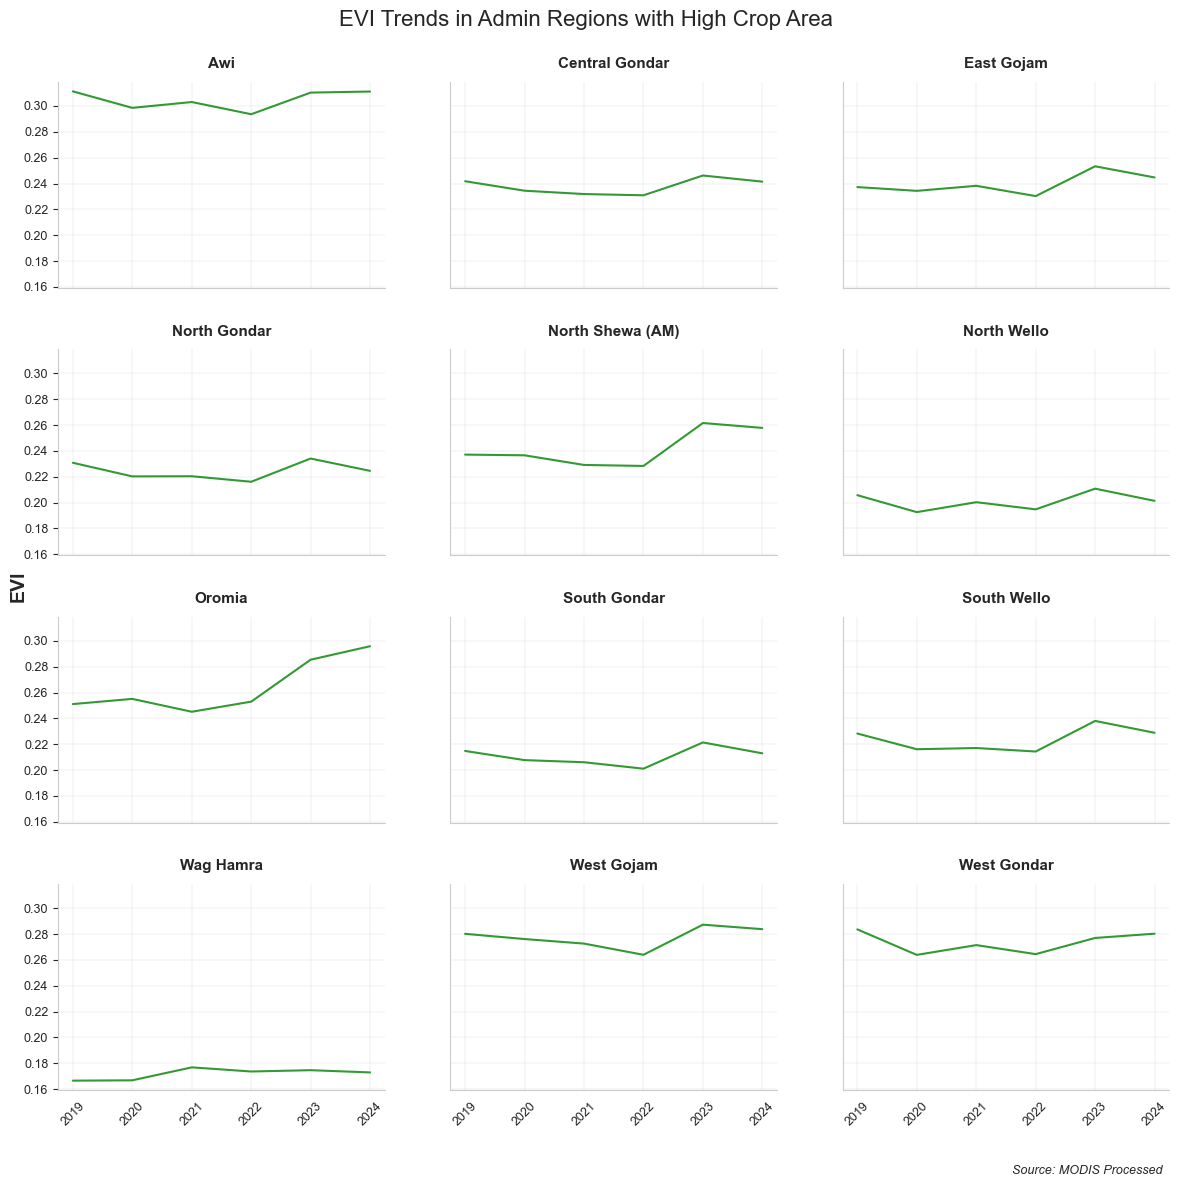

In [119]:
fig = get_trend_plot(evi_median_annual_adm2, crop_admin2_regions, 'EVI Trends in Admin Regions with High Crop Area', show_trend=False)

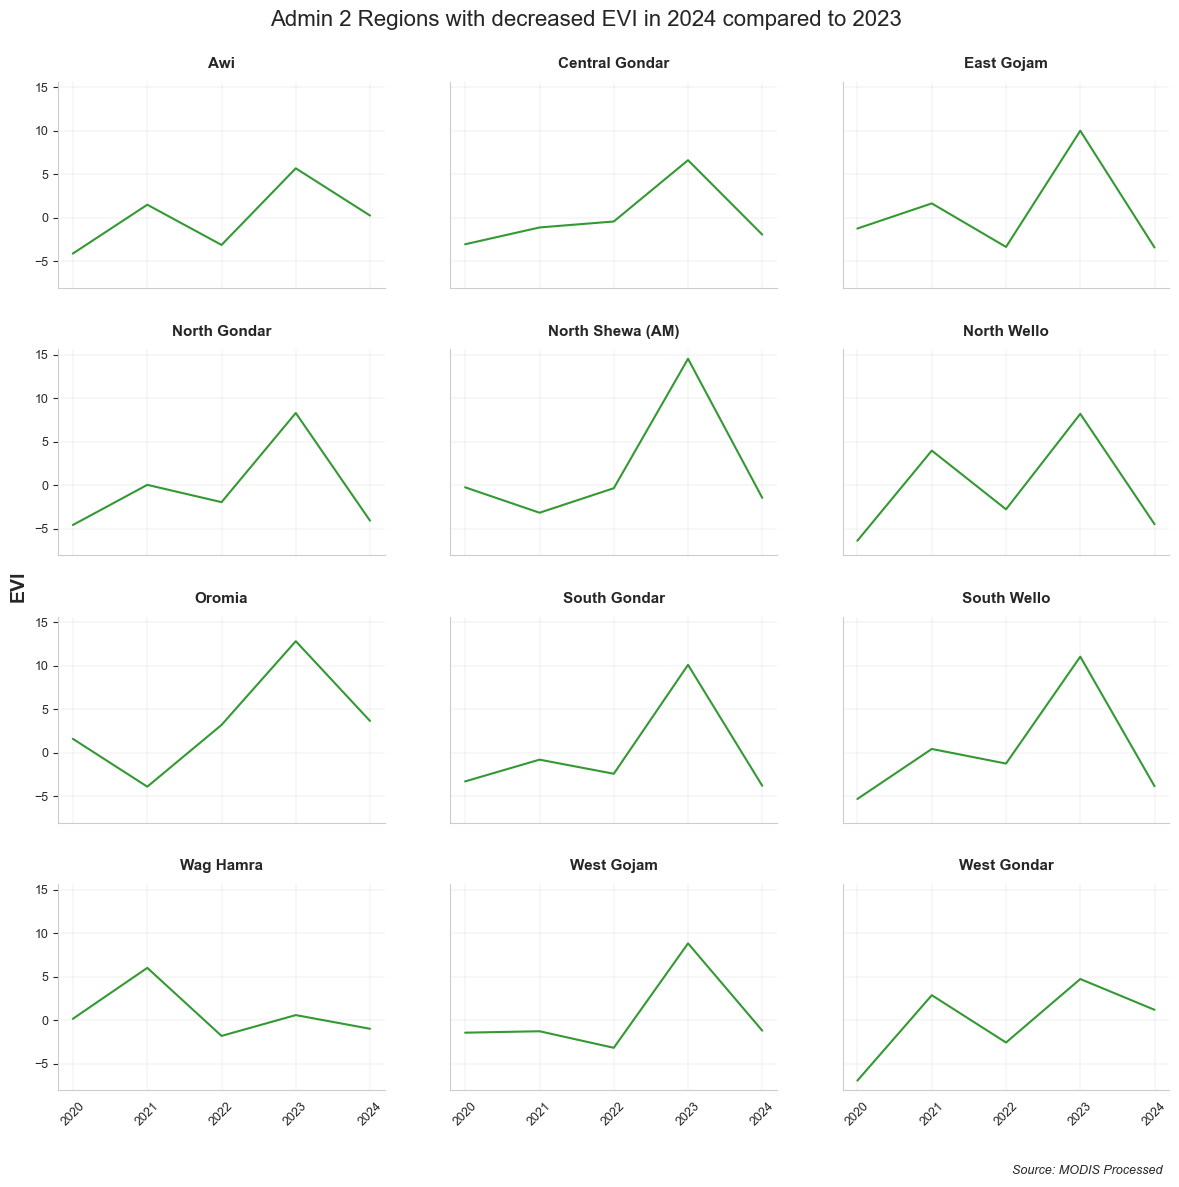

In [159]:
fig = get_trend_plot(evi_median_annual_adm2, crop_admin2_regions, 'Admin 2 Regions with decreased EVI in 2024 compared to 2023', show_trend=False, column='percent_change_median_PY')

In [171]:
for i in range(len(zscore_gdf_adm2)):
    zscore_gdf_adm2[i]['year'] = 2019 + i

pd.concat(zscore_gdf_adm2)[['ADM2_EN', 'ADM1_EN', 'ADM1_PCODE',
       'ADM0_EN', 'ADM0_PCODE', 'year',
       'mean', 'count', 'std', 'median']].to_csv('../../data/agriculture/processed/eth_zscore_adm2_2019_2024.csv', index=False)